# Logistic Regression

The requirement is to use Neural Network models to predict the traffic demand given the historical data. In this case I am using a single **Logistic Regression Model** with **1 hidden layer**.

First, we need to import all the libraries that we are going to need to complete the task. As a library, we will be using **pyTorch**. Also, for the data preprocessing we are using **numpy**, and for the visualization we will be using **pyplot**.

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

## Data Preprocessing

### Importing Training Data

In [5]:
train = np.load('train.npz')
input_train = train['x'] #feature matrix
label_train = train['y'] #label matrix
location_train = train['locations'] #location matrix### Importing Valuation Data
times_train = train['times'] #time matrix

### Importing Valuation Data

In [6]:
val = np.load('val.npz')
input_val = val['x'] #feature matrix
label_val = val['y'] #label matrix
location_val = val['locations'] #location matrix
times_val = val['times'] #time matrix

### Importing Testing Data

In [7]:
test = np.load('test.npz')
input_test = test['x'] #feature matrix
location_test = test['locations'] #location matrix
times_test = test['times'] #time matrix

## Changing from NumPy Arrays into Tensors

Here we are creating tensors from numpy arrays

In [8]:
inputs_train = torch.from_numpy(input_train)
labels_train = torch.from_numpy(label_train)

inputs_val = torch.from_numpy(input_val)
labels_val = torch.from_numpy(label_val)

In [9]:
train_ds = TensorDataset(inputs_train.float(), labels_train.float())
val_ds = TensorDataset(inputs_val.float(), labels_val.float())

### Creating DataLoader

Now, we are creating dataloaders to load the data in batches (in our case we will be using batches of size 100).

Since the training data is often sorted by the target labels, or at least it is not random, therefore, it is crucial for us to choose random data items for our batches.

In [10]:
batch_size = 100
input_size = 8*49

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

### Shape

Here, we can see that our items in the train_loader have the shape of (100(number of items in the batch), 8, 49). But for ou rfurther operations such as matrix multiplications, this shape is going to be invalid for us. Therefore, we need to reshape it.

In [11]:
for items, labels in train_loader:
    print('items.shape:', items.shape)
    inputs = items.reshape(-1, 8*49)
    print('inputs.shape:', inputs.shape)
    break

items.shape: torch.Size([100, 8, 49])
inputs.shape: torch.Size([100, 392])


The size of the hidden layer is going to be 64.

In [12]:
input_size = inputs.shape[-1]
hidden_size = 64

### Layer Creation

Next, we will create a nn.Linear object that is going to be our hidden layer. The size is already defined to be 64.

In [19]:
L1 = nn.Linear(input_size, hidden_size)

In [20]:
L1_outputs = L1(inputs)
print('layer1_outputs.shape:', L1_outputs.shape)

layer1_outputs.shape: torch.Size([100, 64])


In [21]:
L1_outputs_direct = inputs @ L1.weight.t() + L1.bias
L1_outputs_direct.shape

torch.Size([100, 64])

The image of vectors of size 392 are now transformed into intermediate output vectors of lenght 64 after matrix multiplications and addition of bias.

### Activation Function

L1_outputs and inputs have a linear relationship, where each element of L1_putputs is a weighted sum of elements of unputs. Therefore, layer 1 can only capture linear relationships. That is why we need some kind of function that would make the next relationship between L1 and L2 non-linear.

This kind of function is called an activation function and there are typically 5 major functions which are Step, Tanh, ReLU, and leaky ReLU.

In our case, we will be using ReLU (Rectified Linear Unit) as an activation function. What it does is it ignores the non-negative numbers, but the negative numbers are transformed to 0. This function is no derivativable, and therefore is a good choice for a function to get rid from linearity. 

In [22]:
relu_outputs = F.relu(L1_outputs)
print('min(L1_outputs):', torch.min(L1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(L1_outputs): -56.520835876464844
min(relu_outputs): 0.0


### Creation of Layer 2

In [23]:
L2 = nn.Linear(hidden_size, 1)

In [24]:
L2_outputs = L2(relu_outputs)
print(L2_outputs.shape)

torch.Size([100, 1])


Now, layer 2 outputs contains a batch of vectors of size 1. Now, we can compute the loss using F.mse_loss (Mean Squared Loss) function and adjust the weights of L1 and L2 using gradient descent.

In [25]:
F.mse_loss(L2_outputs, labels)

tensor(470.2571, grad_fn=<MseLossBackward0>)

In [26]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ L1.weight.t() + L1.bias)) @ L2.weight.t() + L2.bias

In [27]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ L1.weight.t() + L1.bias) @ L2.weight.t() + L2.bias

In [30]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, 1)

combined_layer.weight.data = L2.weight @ L1.weight
combined_layer.bias.data = L1.bias @ L2.weight.t() + L2.bias

In [31]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

### Defining Model

Here we will define our own class of Model, that will be extended from nn.Linear model with some minor additions such as reshaping and applying a hidden layer. 

In [32]:
class MyModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        xb = xb.view(-1, 8*49)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        items, labels = batch 
        out = self(items)
        loss = F.mse_loss(out, labels)
        return loss
    
    def validation_step(self, batch):
        items, labels = batch 
        out = self(items)
        loss = F.mse_loss(out, labels)
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [33]:
model = MyModel(input_size, hidden_size=32, out_size=1)

In [34]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 392])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


Here from model parameters we can see how the sizes of our batches are changing with each layer.

### Evaluate and Fit Functions

Now, it is time to define the evaluate and fit functions.

The evaluate() function will be checking the performance of the model on the validation loader.

The fit() function is going to be a function that is handling the training of the model and applying the backward() process that will be making the model better overtime.

In [35]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 341.6239013671875}]

In [37]:
history += fit(20, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 24.5951
Epoch [1], val_loss: 22.1745
Epoch [2], val_loss: 21.4285
Epoch [3], val_loss: 21.3776
Epoch [4], val_loss: 21.8017
Epoch [5], val_loss: 20.5626
Epoch [6], val_loss: 22.3841
Epoch [7], val_loss: 20.2465
Epoch [8], val_loss: 22.6555
Epoch [9], val_loss: 19.7944
Epoch [10], val_loss: 19.8502
Epoch [11], val_loss: 20.8647
Epoch [12], val_loss: 21.4028
Epoch [13], val_loss: 20.2443
Epoch [14], val_loss: 19.7907
Epoch [15], val_loss: 19.4051
Epoch [16], val_loss: 20.3620
Epoch [17], val_loss: 19.3020
Epoch [18], val_loss: 20.1297
Epoch [19], val_loss: 19.6405


In [38]:
history += fit(20, 1e-5, model, train_loader, val_loader)

Epoch [0], val_loss: 18.6308
Epoch [1], val_loss: 18.6759
Epoch [2], val_loss: 18.5793
Epoch [3], val_loss: 18.5551
Epoch [4], val_loss: 18.5984
Epoch [5], val_loss: 18.5959
Epoch [6], val_loss: 18.6486
Epoch [7], val_loss: 18.5891
Epoch [8], val_loss: 18.5588
Epoch [9], val_loss: 18.5969
Epoch [10], val_loss: 18.5723
Epoch [11], val_loss: 18.6045
Epoch [12], val_loss: 18.5993
Epoch [13], val_loss: 18.6262
Epoch [14], val_loss: 18.6135
Epoch [15], val_loss: 18.5833
Epoch [16], val_loss: 18.6069
Epoch [17], val_loss: 18.5931
Epoch [18], val_loss: 18.6151
Epoch [19], val_loss: 18.5812


In [39]:
history += fit(20, 1e-6, model, train_loader, val_loader)

Epoch [0], val_loss: 18.5565
Epoch [1], val_loss: 18.5551
Epoch [2], val_loss: 18.5509
Epoch [3], val_loss: 18.5530
Epoch [4], val_loss: 18.5494
Epoch [5], val_loss: 18.5490
Epoch [6], val_loss: 18.5530
Epoch [7], val_loss: 18.5514
Epoch [8], val_loss: 18.5552
Epoch [9], val_loss: 18.5509
Epoch [10], val_loss: 18.5516
Epoch [11], val_loss: 18.5524
Epoch [12], val_loss: 18.5457
Epoch [13], val_loss: 18.5507
Epoch [14], val_loss: 18.5540
Epoch [15], val_loss: 18.5522
Epoch [16], val_loss: 18.5506
Epoch [17], val_loss: 18.5513
Epoch [18], val_loss: 18.5501
Epoch [19], val_loss: 18.5498


In [40]:
history += fit(20, 1e-7, model, train_loader, val_loader)

Epoch [0], val_loss: 18.5492
Epoch [1], val_loss: 18.5490
Epoch [2], val_loss: 18.5489
Epoch [3], val_loss: 18.5489
Epoch [4], val_loss: 18.5487
Epoch [5], val_loss: 18.5486
Epoch [6], val_loss: 18.5486
Epoch [7], val_loss: 18.5484
Epoch [8], val_loss: 18.5484
Epoch [9], val_loss: 18.5483
Epoch [10], val_loss: 18.5483
Epoch [11], val_loss: 18.5483
Epoch [12], val_loss: 18.5483
Epoch [13], val_loss: 18.5482
Epoch [14], val_loss: 18.5482
Epoch [15], val_loss: 18.5481
Epoch [16], val_loss: 18.5481
Epoch [17], val_loss: 18.5480
Epoch [18], val_loss: 18.5480
Epoch [19], val_loss: 18.5480


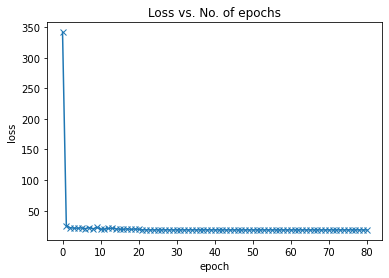

In [41]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

After running a several number of epochs we can see that our val_loss (mse_loss) is on the level of 18.4. Also, from the graph we can see that the model flattened already after about 10 epochs. This is a quite good result for the model.

Now let's predict the values on the testing data.

In [42]:
inputs_test = torch.from_numpy(input_test)

test = model(inputs_test.float())
test

tensor([[1.3432],
        [1.5512],
        [1.3817],
        ...,
        [4.3431],
        [5.5608],
        [4.5661]], grad_fn=<AddmmBackward0>)

Now, we will save the model for the submission.

In [43]:
torch.save(model.state_dict(), 'chicago.pth')

In [44]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-0.0157, -0.0224, -0.0335,  ...,  0.0243,  0.0615,  0.0363],
                      [ 0.0058,  0.0220, -0.0516,  ..., -0.0410, -0.0263,  0.0249],
                      [ 0.0160,  0.0183,  0.0377,  ...,  0.0254,  0.0734,  0.0629],
                      ...,
                      [-0.0449,  0.0221,  0.0253,  ...,  0.0126,  0.0391,  0.0426],
                      [-0.0360,  0.0017, -0.0185,  ...,  0.0313, -0.0124, -0.0118],
                      [-0.0208,  0.0081, -0.0315,  ...,  0.0074,  0.0234,  0.0143]])),
             ('linear1.bias',
              tensor([ 0.0214,  0.0077,  0.0914,  0.0330, -0.0495,  0.0214,  0.0298,  0.0355,
                      -0.0634,  0.0434, -0.0226,  0.0031,  0.0023,  0.0908, -0.0465,  0.0310,
                       0.0293,  0.0211, -0.0026, -0.0298, -0.0428, -0.0056, -0.0307, -0.0551,
                      -0.0117,  0.0438, -0.0282,  0.0184, -0.0402,  0.0194, -0.0464,  0.0121])),
             ('linear2.we

--------------------------------------------------------------------------------

The model was trained on the training and validation sets and showed an mse_loss of around 18.4 (Since, it is squared we can assume that the mean average error would be around sqrt18.4 or 4.3). But, there are still losses in the model. For example, more hidden layers can be added to the model or we can use different activation function. Since, the model had only one hidden layer it is not as efficient as Deep Neural Networks such as CNN and RNN, but for the task, it should give the good result in predicting the traffic demand for the next step.